In [4]:
!pip install kaggle

## Importing requisite libraries

In [11]:

import pandas
import os
os.environ['KAGGLE_USERNAME']="sanjeevns20mia1058"
os.environ['KAGGLE_KEY']="a341c1c05a18d82d079bd812dd180ef1"

In [12]:
!kaggle competitions download -c osic-pulmonary-fibrosis-progression

100% 13.3G/13.3G [02:30<00:00, 157MB/s]
100% 13.3G/13.3G [02:30<00:00, 95.4MB/s]


In [13]:
!unzip osic-pulmonary-fibrosis-progression.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/ID00370637202296737666151/139.dcm  
  inflating: train/ID00370637202296737666151/14.dcm  
  inflating: train/ID00370637202296737666151/140.dcm  
  inflating: train/ID00370637202296737666151/141.dcm  
  inflating: train/ID00370637202296737666151/142.dcm  
  inflating: train/ID00370637202296737666151/143.dcm  
  inflating: train/ID00370637202296737666151/144.dcm  
  inflating: train/ID00370637202296737666151/145.dcm  
  inflating: train/ID00370637202296737666151/146.dcm  
  inflating: train/ID00370637202296737666151/147.dcm  
  inflating: train/ID00370637202296737666151/148.dcm  
  inflating: train/ID00370637202296737666151/149.dcm  
  inflating: train/ID00370637202296737666151/15.dcm  
  inflating: train/ID00370637202296737666151/150.dcm  
  inflating: train/ID00370637202296737666151/151.dcm  
  inflating: train/ID00370637202296737666151/152.dcm  
  inflating: train/ID00370637202296737666151/153.dcm  
  inflating: tra

In [15]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.6 MB/s eta 0:00:00


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import matplotlib.pyplot as plt
import pydicom as dicom

import os
from tqdm import tqdm

# Loading Image Data

In [17]:
def load_image(path):
    ds=dicom.dcmread(path)
    img = ds.pixel_array                                  # Now, img is pixel_array. it is input of our demo code
                                                          # Convert pixel_array (img) to -> gray image (img_2d_scaled)
    img_2d = img.astype(float)                            # Step 1. Convert to float to avoid overflow or underflow losses.
    img = (np.maximum(img_2d,0) / img_2d.max()) * 255.0   # Step 2. Rescaling grey scale between 0-255
    return img

100%|██████████| 6/6 [00:00<00:00, 42.98it/s]


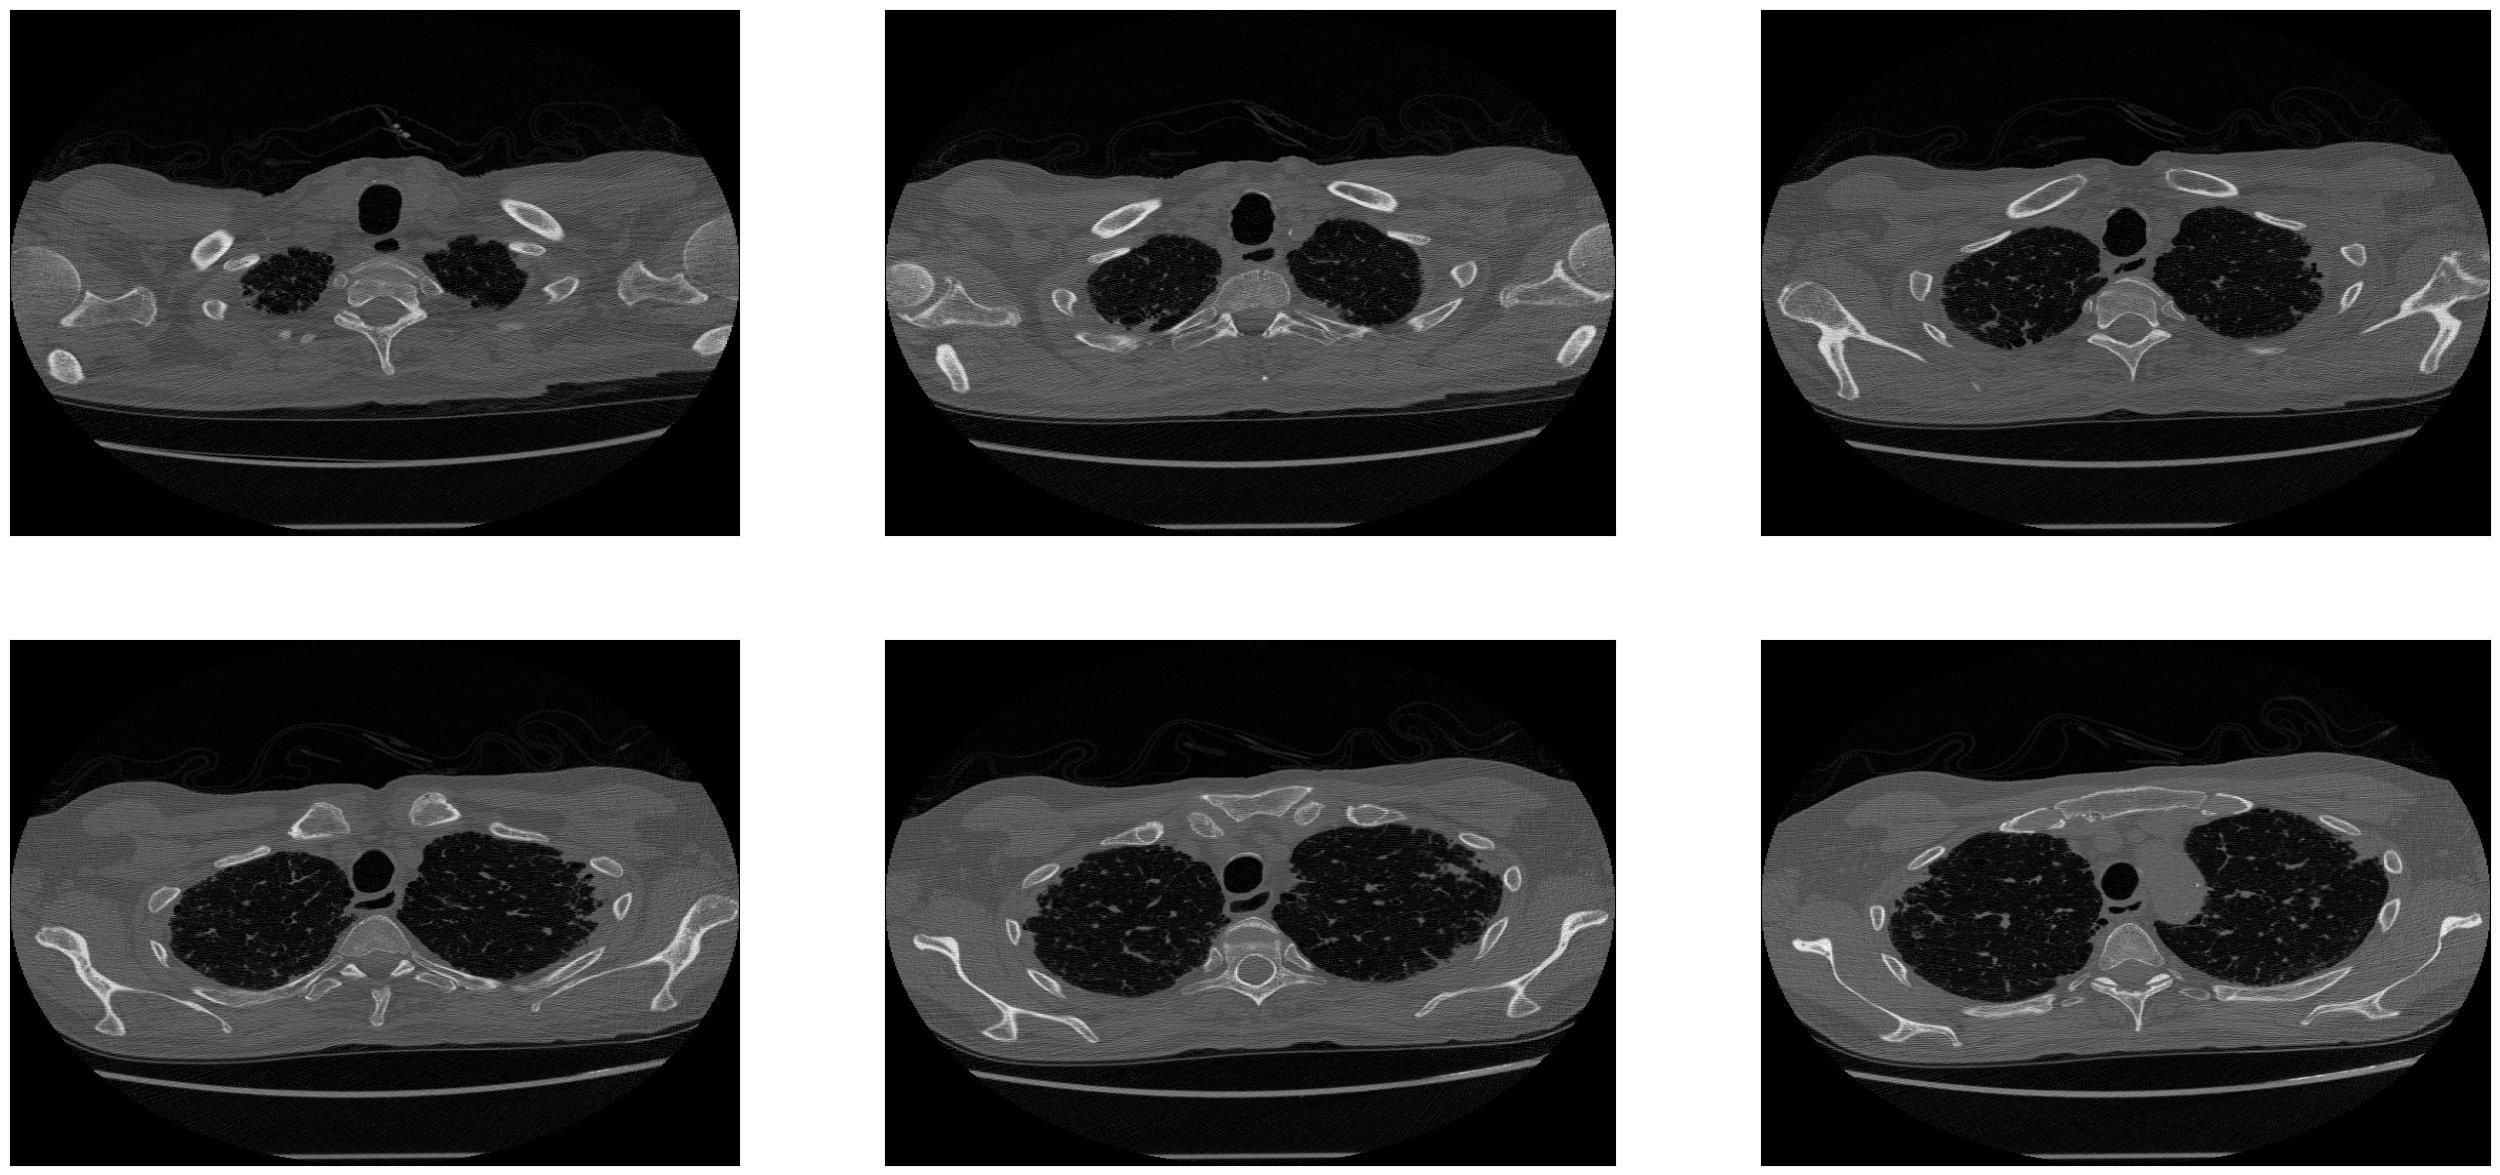

In [18]:
def show_images():
    f, ax= plt.subplots(2,3, figsize=(32, 15))
    for i in tqdm(range(6)):
        path='/content/train/ID00007637202177411956430'
        img_path=os.path.join(path, str(i+3))
        img_path=img_path+'.dcm'

        img= load_image(img_path)
        ax[i//3][i%3].imshow(img, aspect='auto', cmap='gray')
        ax[i//3][i%3].set_xticks([]); ax[i//3][i%3].set_yticks([])
    plt.show()

show_images()

## Thresholding Images

100%|██████████| 6/6 [00:00<00:00, 74.32it/s]


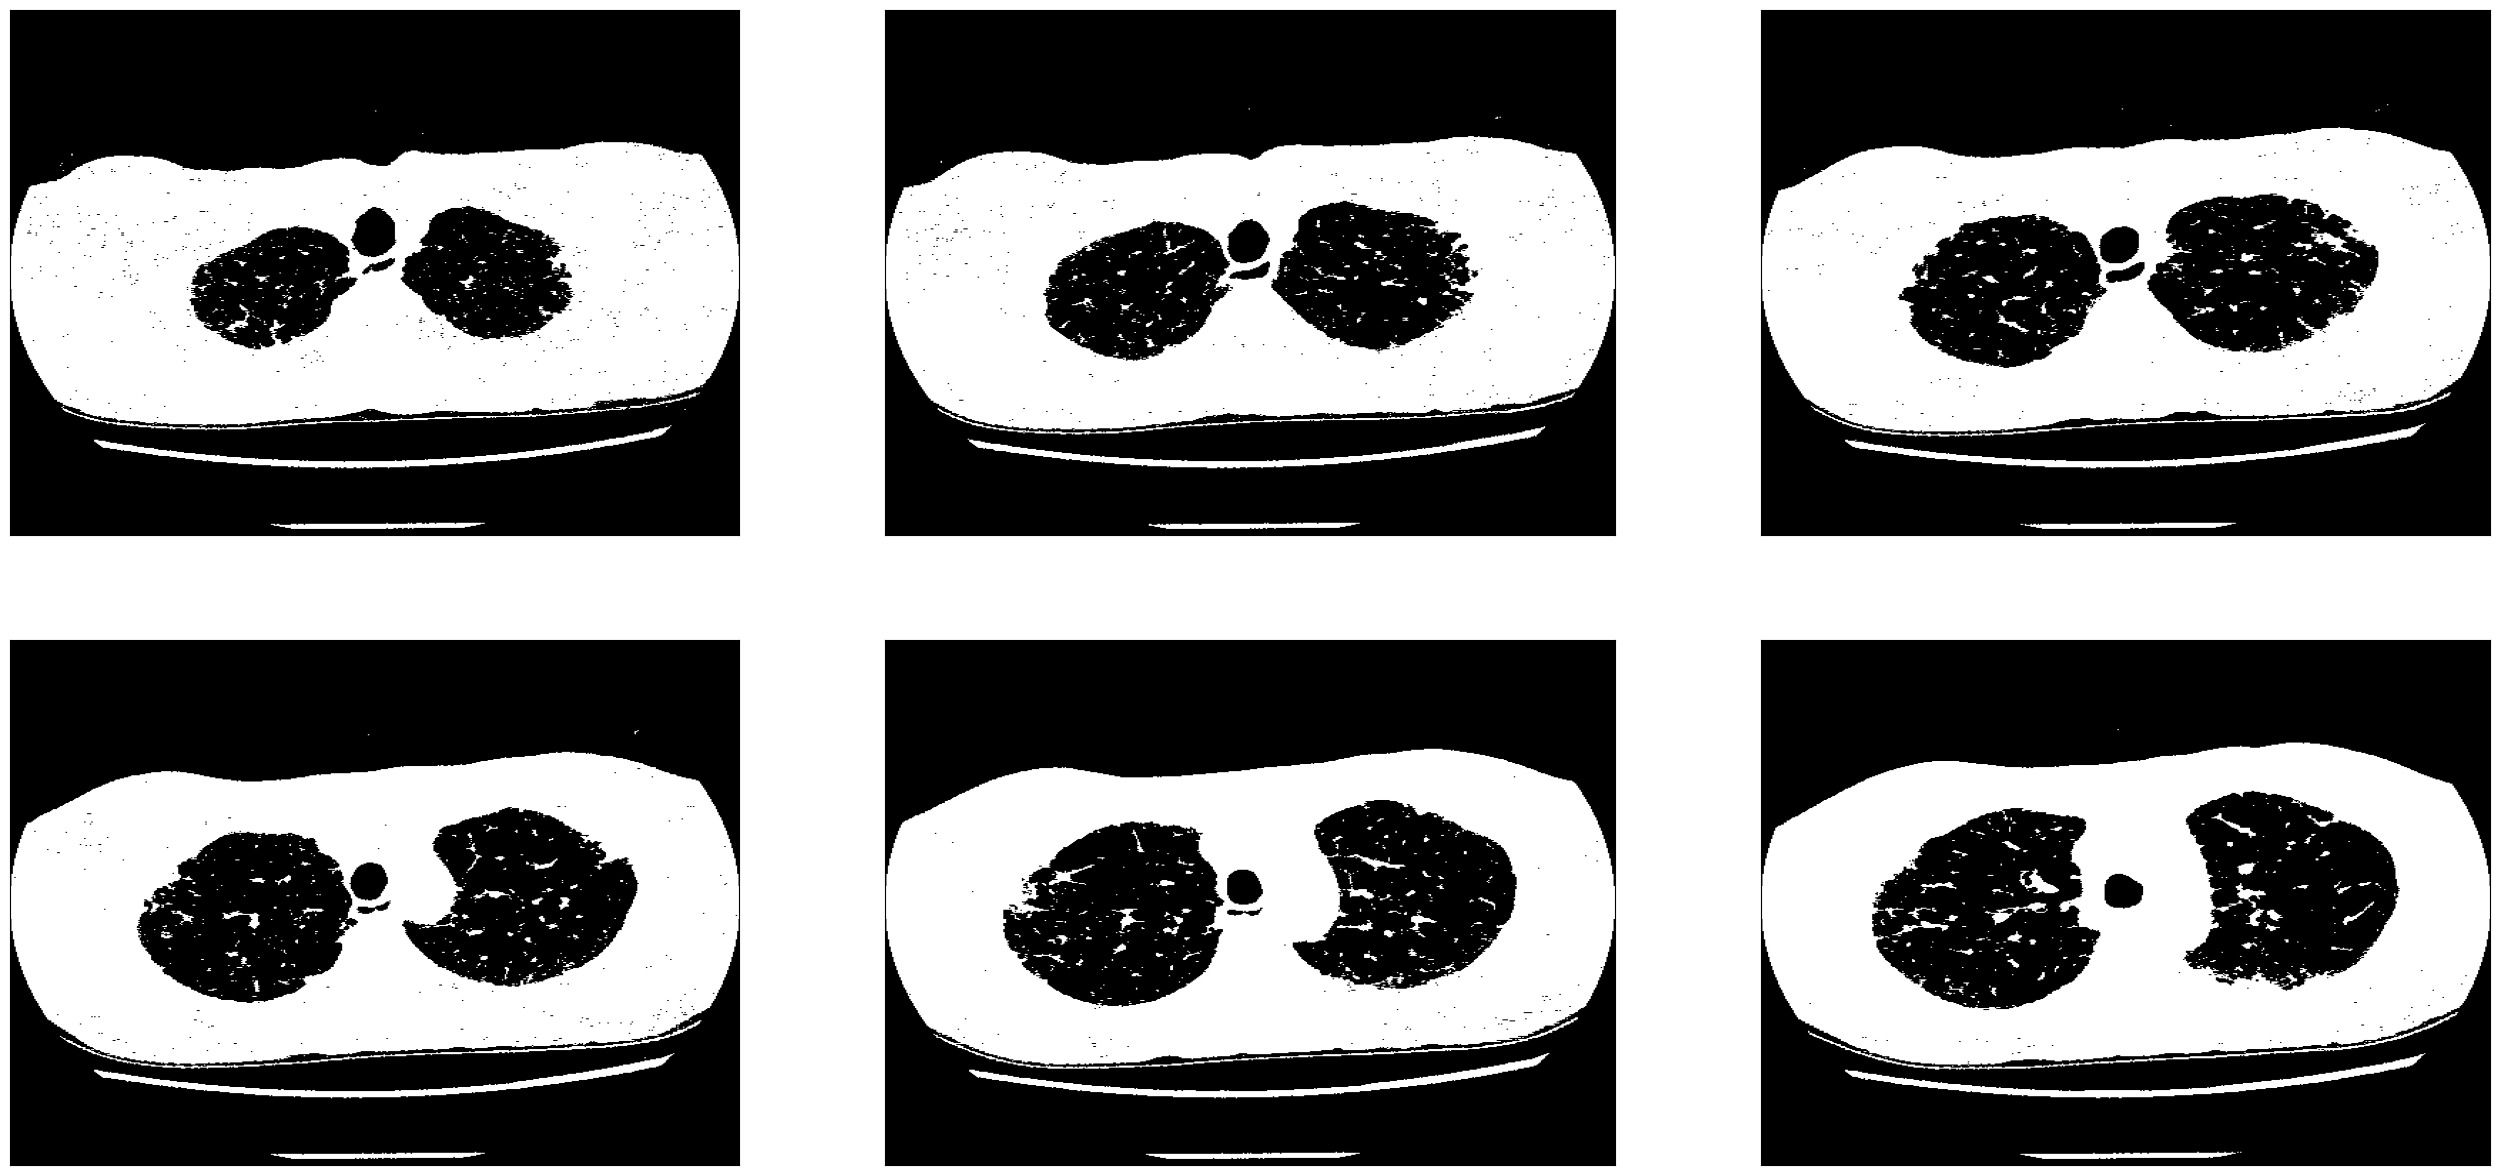

In [19]:
def show_THR_img():
    f, ax= plt.subplots(2,3, figsize=(32, 15))
    for i in tqdm(range(6)):
        path='/content/train/ID00007637202177411956430'
        img_path=os.path.join(path, str(i+5))
        img_path=img_path+'.dcm'

        img= load_image(img_path)
        img_thr= cv2.threshold(img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)[1]
        ax[i//3][i%3].imshow(img_thr, aspect='auto', cmap='gray')
        ax[i//3][i%3].set_xticks([]); ax[i//3][i%3].set_yticks([])
    plt.show()

show_THR_img()

# Finding Contours + hierarchical operations

In [20]:
def find_contour(img_thr, find_max_con=False):
    contours,hierarchy,=cv2.findContours(img_thr,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    # Max area contour
    if find_max_con:
        contours,hierarchy,=cv2.findContours(img_thr,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        max_con= max(contours,key=cv2.contourArea)

        mask=np.zeros(img_thr.shape)
        mask= cv2.fillConvexPoly(mask, max_con, 1.0)

        return img_thr * mask


    # EXTERNAL CONTOUR
    ext_contours=np.zeros(img_thr.shape)
    for i in range(len(contours)):
        if hierarchy[0][i][3]==-1:  # checking for ext. contour (-1)  else 'specific no' for diff. internal contours
            cv2.drawContours(ext_contours,contours,i,255,-1)

    # INTERNAL CONTOUR
    int_contours=np.zeros(img_thr.shape)
    for i in range(len(contours)):
        if hierarchy[0][i][3]!= -1:  # checking for ext. contour (-1)  else internal contour
            cv2.drawContours(int_contours,contours,i,255,-1)
    return ext_contours, int_contours

100%|██████████| 6/6 [00:00<00:00,  7.87it/s]


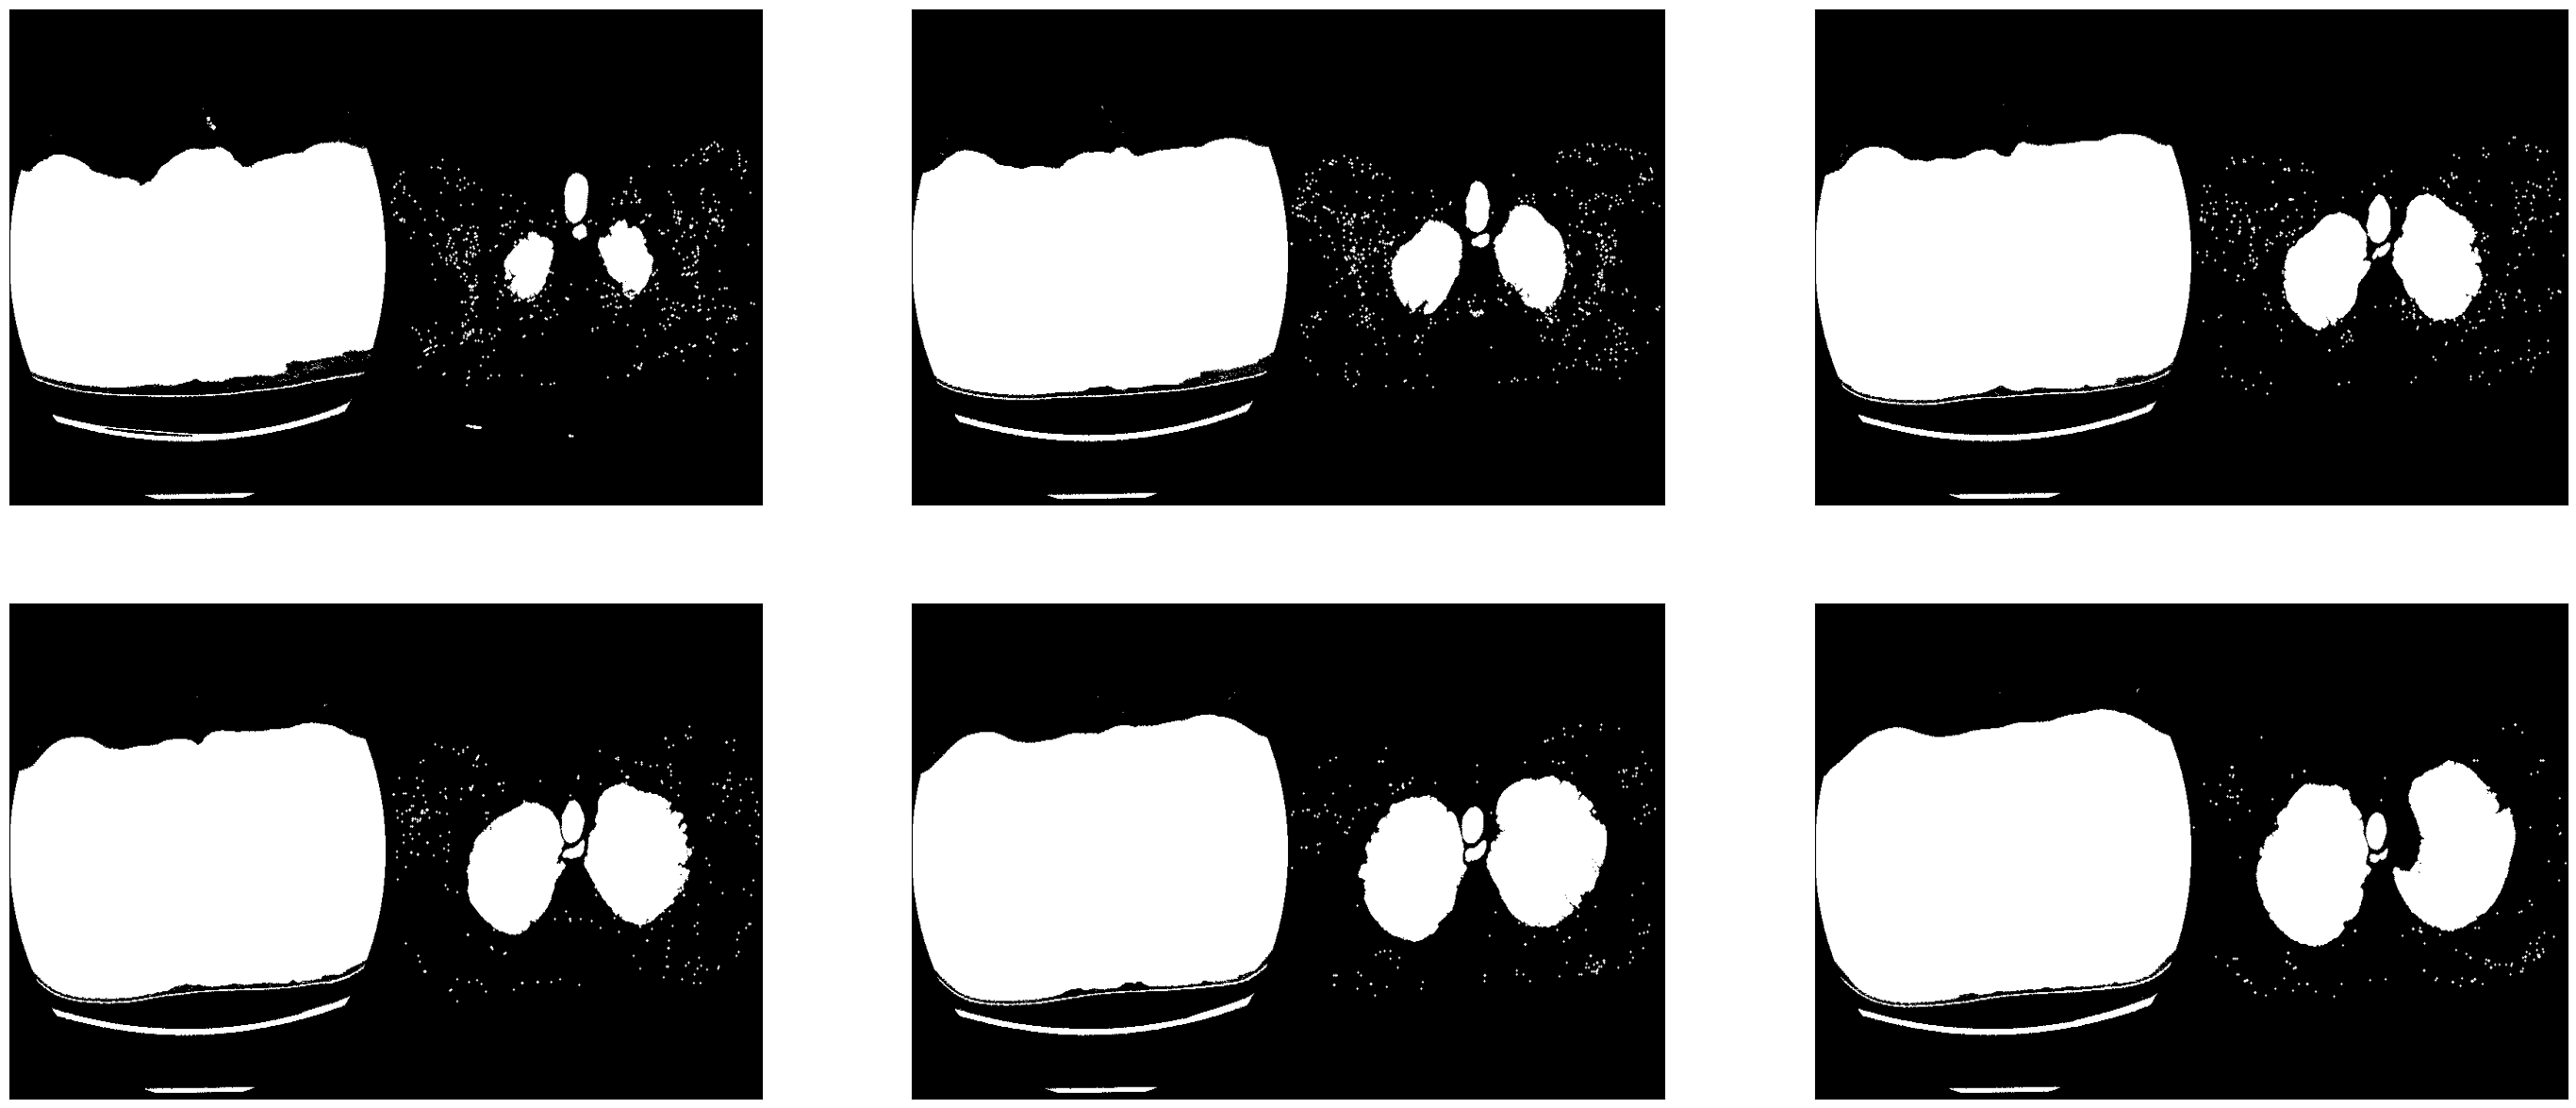

In [21]:
def show_contour_img():
    f, ax= plt.subplots(2,3, figsize=(35, 15))
    for i in tqdm(range(6)):
        path='/content/train/ID00007637202177411956430'
        img_path=os.path.join(path, str(i+3))
        img_path=img_path+'.dcm'

        img= load_image(img_path)
        img_thr= cv2.threshold(img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)[1]
        ex_con, in_con= find_contour(img_thr)
        ax[i//3][i%3].imshow(np.hstack([ex_con, in_con]), aspect='auto', cmap='gray')
        ax[i//3][i%3].set_xticks([]); ax[i//3][i%3].set_yticks([])
    plt.show()

show_contour_img()

# Lung segmentation and Masking

In [22]:
def seg_lung(org_img, in_contours_img):
    kernel= cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

    clr_noise_img=cv2.morphologyEx(in_contours_img, cv2.MORPH_OPEN, kernel)
    forg_img= cv2.dilate(clr_noise_img, kernel,iterations = 2)

    forg_img= cv2.bitwise_not(forg_img.astype('uint8'))
    return cv2.bitwise_or(org_img.astype('uint8'), forg_img)

### 1st Approach
#### --->Recommended

100%|██████████| 6/6 [00:00<00:00,  7.74it/s]


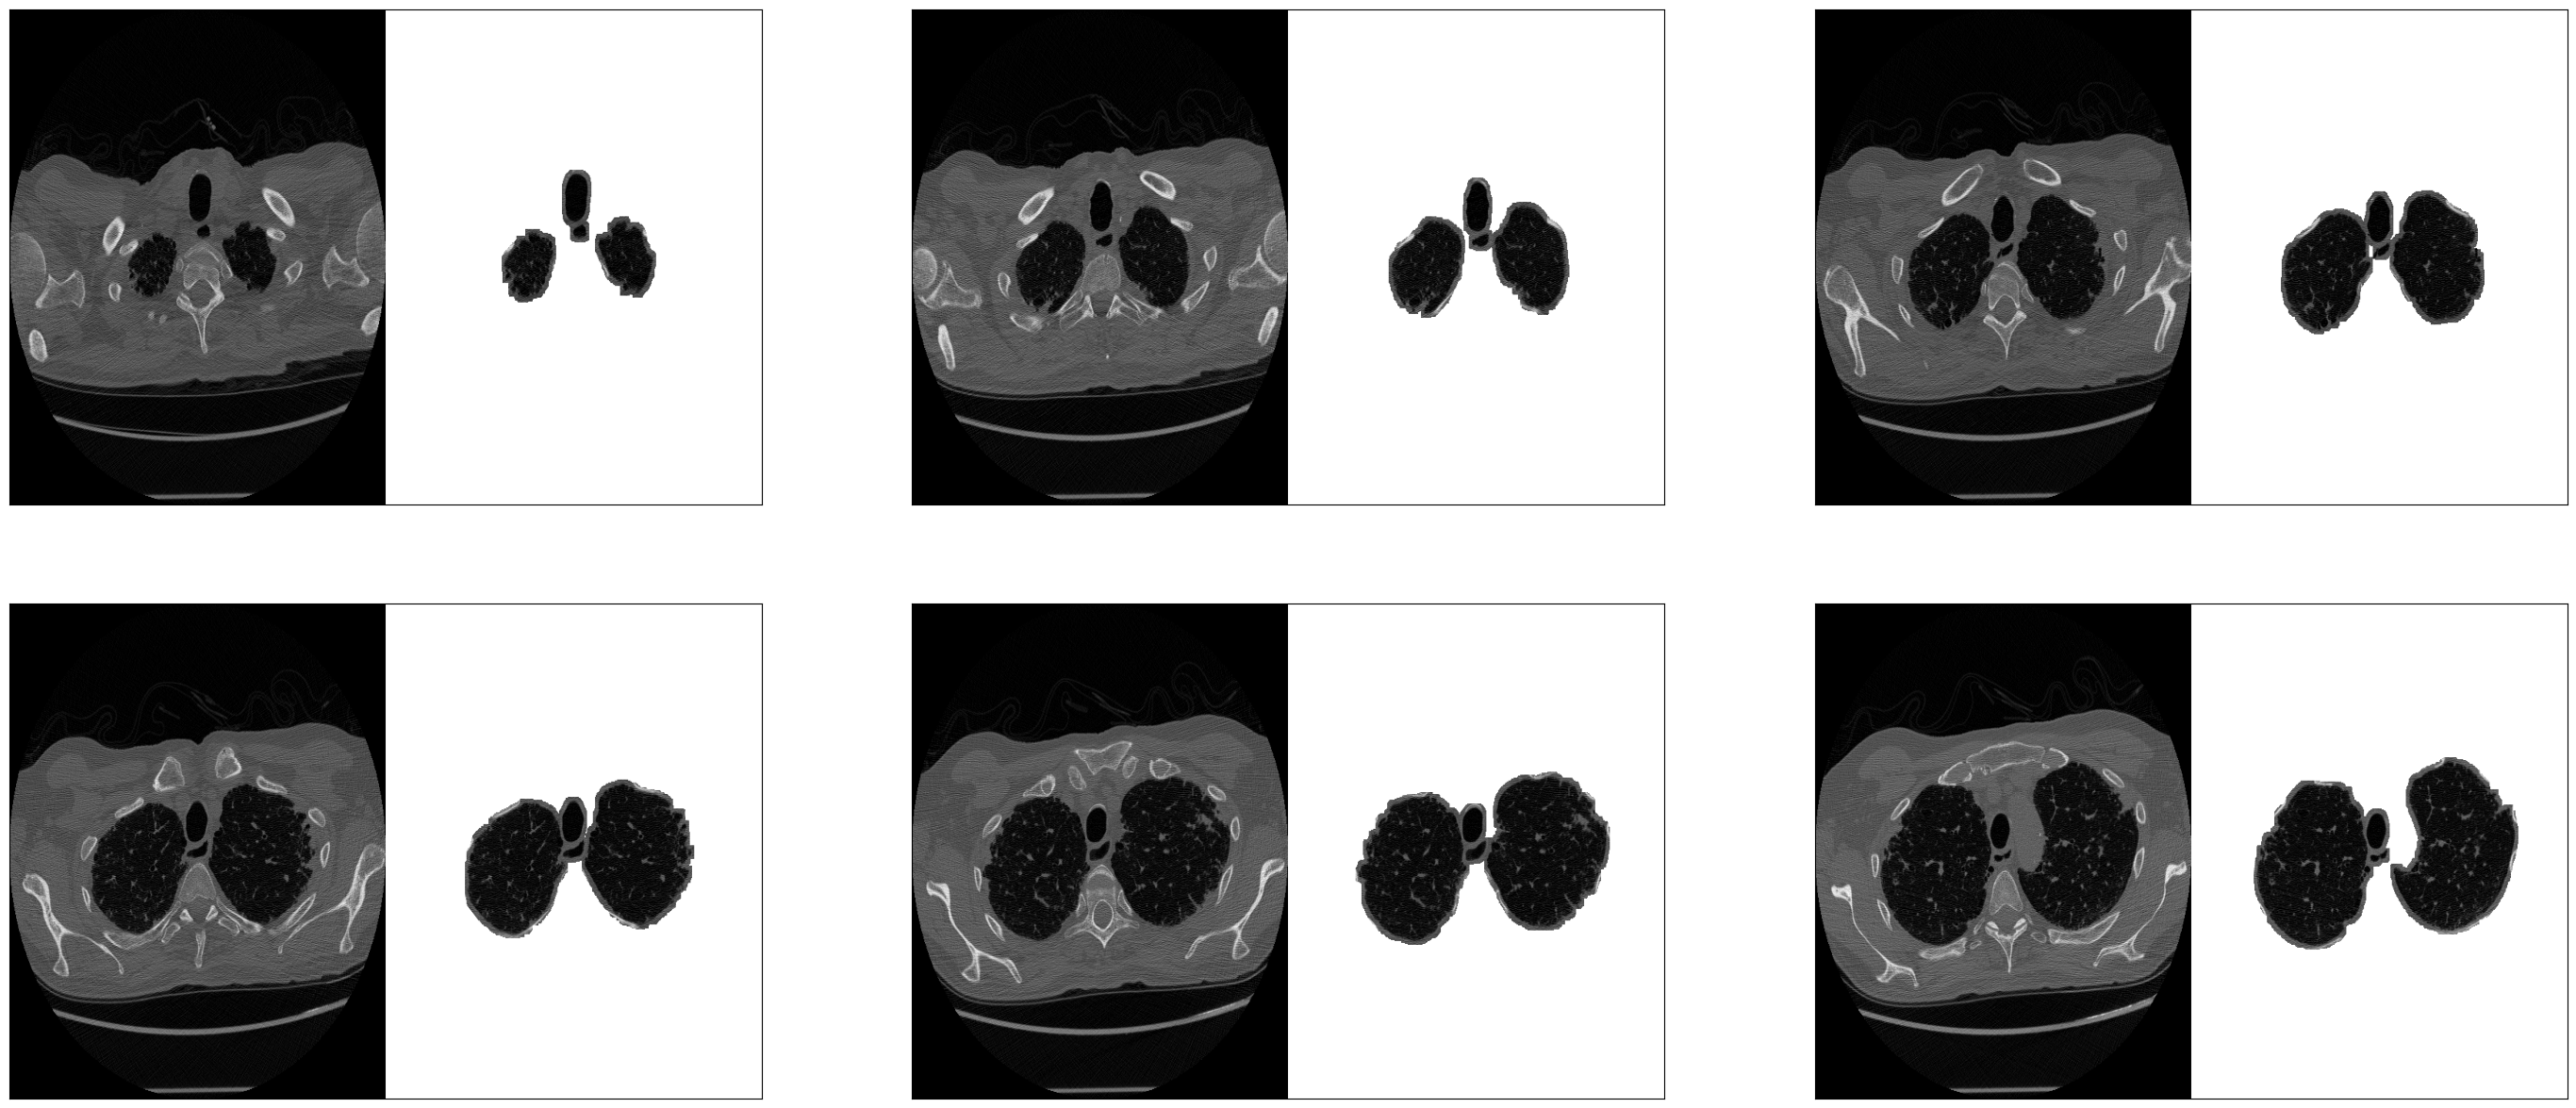

In [23]:

def show_forgrd_img():
    f, ax= plt.subplots(2,3, figsize=(35, 15))
    for i in tqdm(range(6)):
        path='/content/train/ID00007637202177411956430'
        img_path=os.path.join(path, str(i+3))
        img_path=img_path+'.dcm'

        img= load_image(img_path)
        img_thr= cv2.threshold(img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)[1]
        ex_con, in_con= find_contour(img_thr)

        seg_img= seg_lung(img, in_con)
        ax[i//3][i%3].imshow(np.hstack([img, seg_img]), aspect='auto', cmap='gray')
        ax[i//3][i%3].set_xticks([]); ax[i//3][i%3].set_yticks([])
    plt.show()

show_forgrd_img()

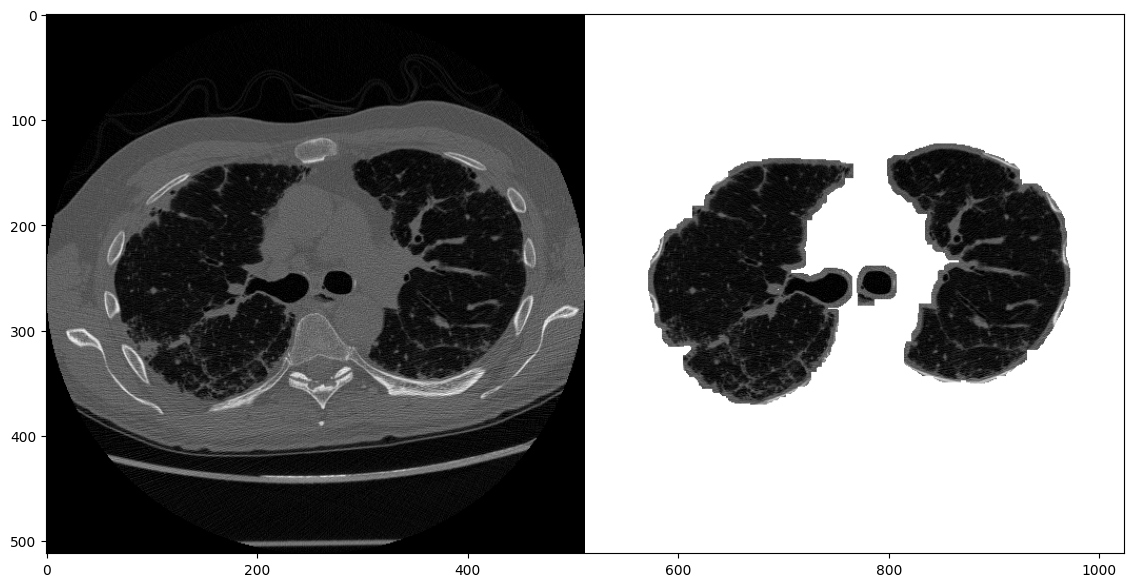

In [24]:
path='/content/train/ID00007637202177411956430/13.dcm'
img= load_image(path)
img_thr= cv2.threshold(img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)[1]
ed_img= cv2.Canny(img_thr, 100, 200)
ex_con, in_con= find_contour(img_thr)
seg_img= seg_lung(img, in_con)

plt.figure(figsize=(16,7))
plt.imshow(np.hstack([img, seg_img]), 'gray')

### 2st Approach

100%|██████████| 6/6 [00:00<00:00,  9.86it/s]


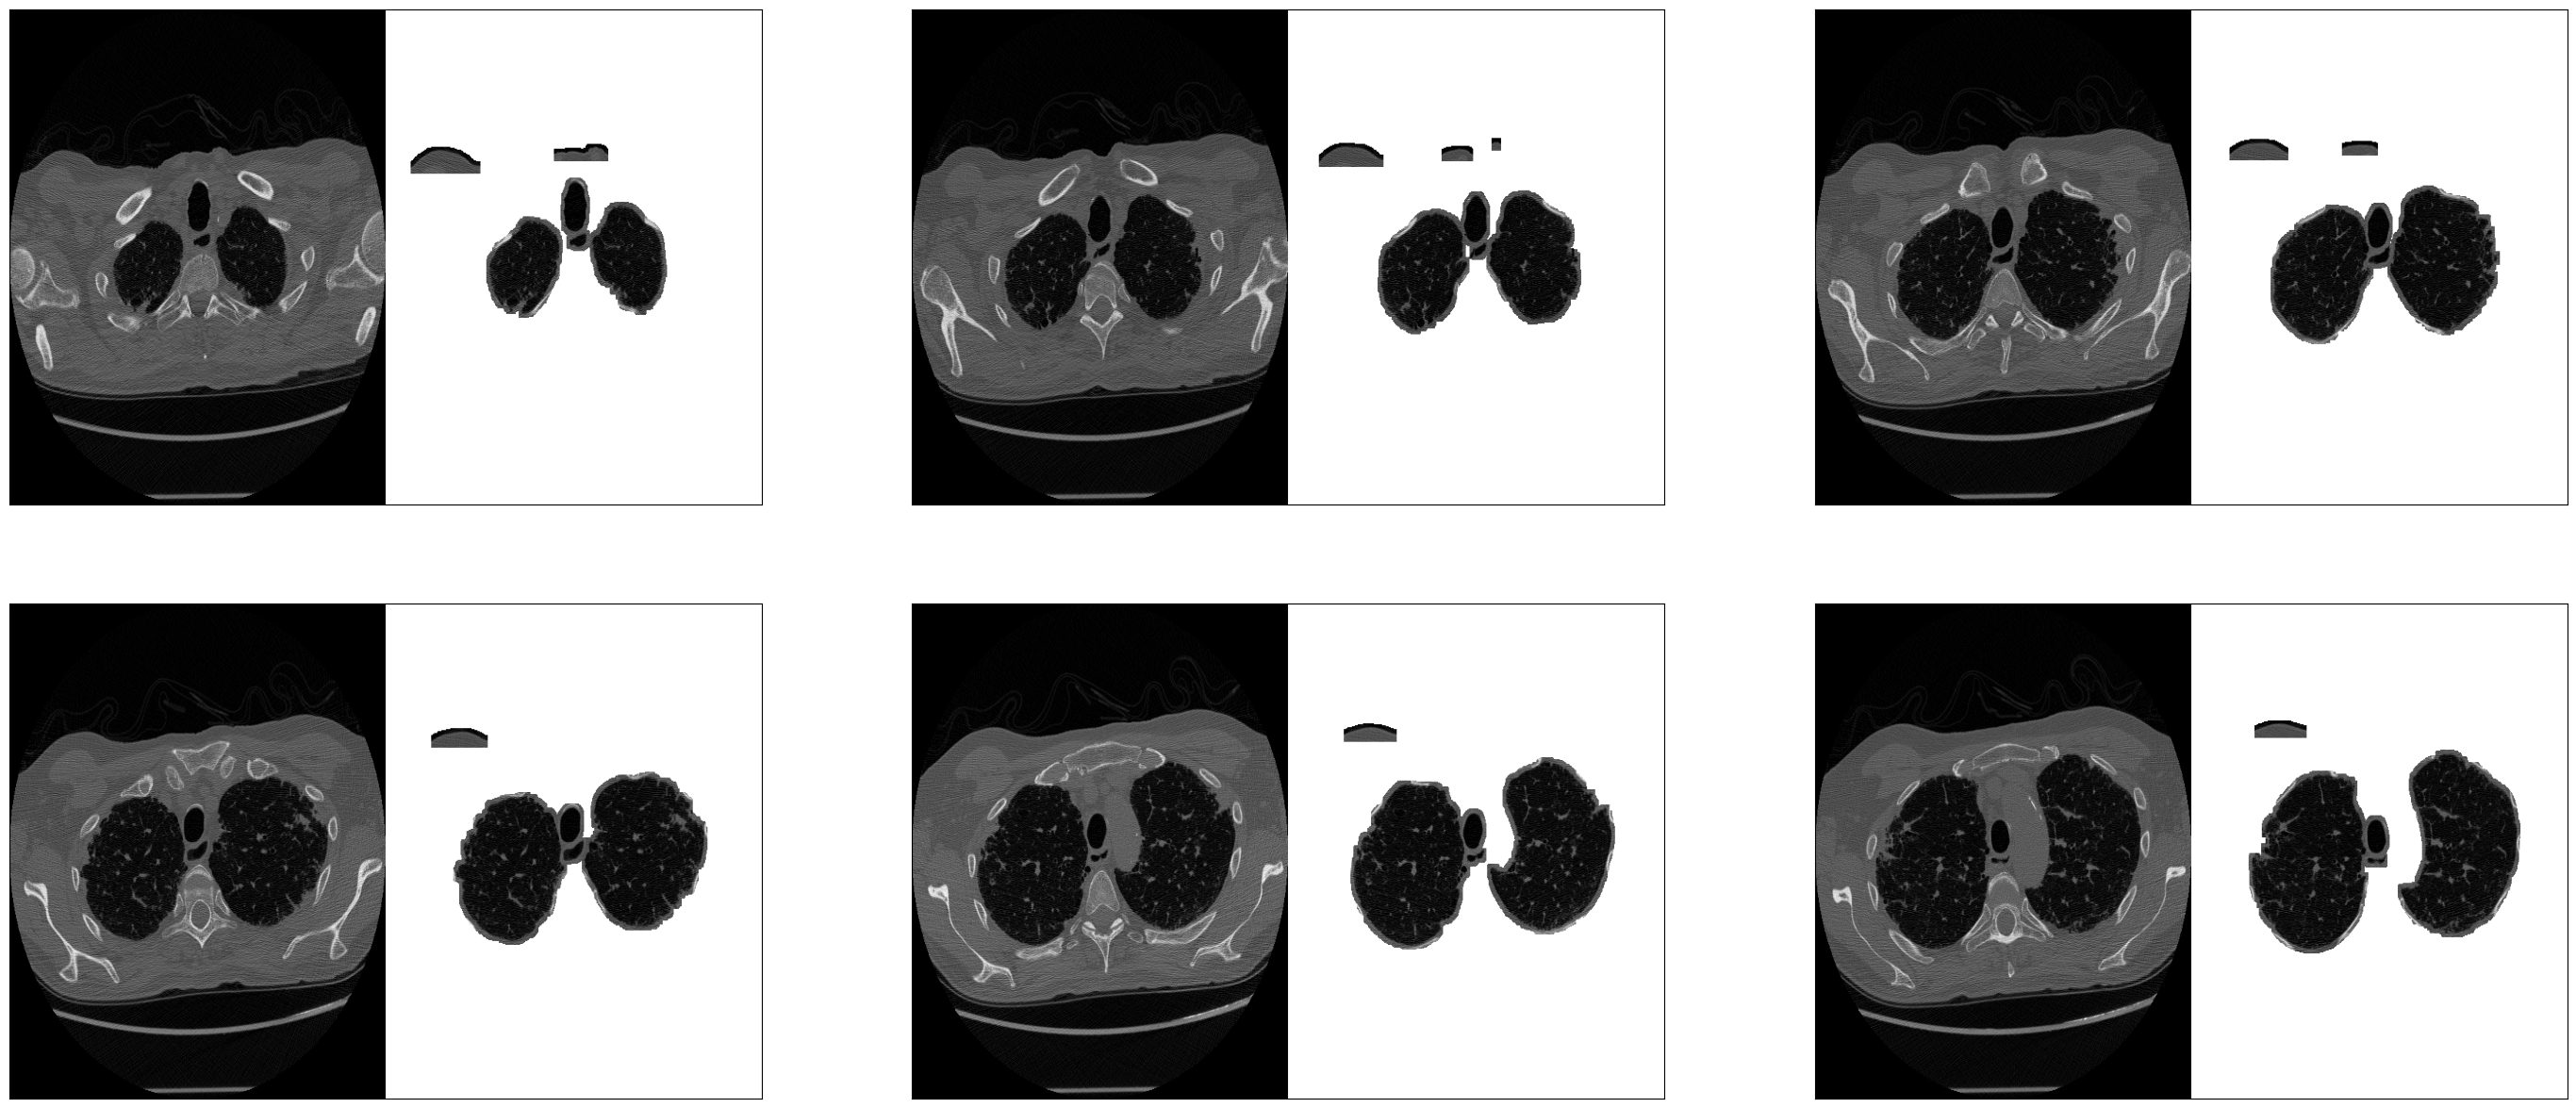

In [25]:

def show_forgrd_img_extra():
    f, ax= plt.subplots(2,3, figsize=(35, 15))
    for i in tqdm(range(6)):
        path='/content/train/ID00007637202177411956430'
        img_path=os.path.join(path, str(i+4))
        img_path=img_path+'.dcm'

        img= load_image(img_path)
        img_thr= cv2.threshold(img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)[1]

        max_con_img= find_contour(img_thr, find_max_con=True)
        img_thr= cv2.threshold(max_con_img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)[1]

        ex_con, in_con= find_contour(img_thr)

        seg_img= seg_lung(img, in_con)
        ax[i//3][i%3].imshow(np.hstack([img, seg_img]), aspect='auto', cmap='gray')
        ax[i//3][i%3].set_xticks([]); ax[i//3][i%3].set_yticks([])
    plt.show()

show_forgrd_img_extra()

In [26]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [27]:
# Stacking images
img=[]
path='/content/train/ID00007637202177411956430/'
for i in range(1, 31):
    path1= path+str(i)+'.dcm'
    image= cv2.resize(load_image(path1), (250,250))
    img.append(image)

print(len(img))
bones=np.array(img)
bones.shape

30


(30, 250, 250)

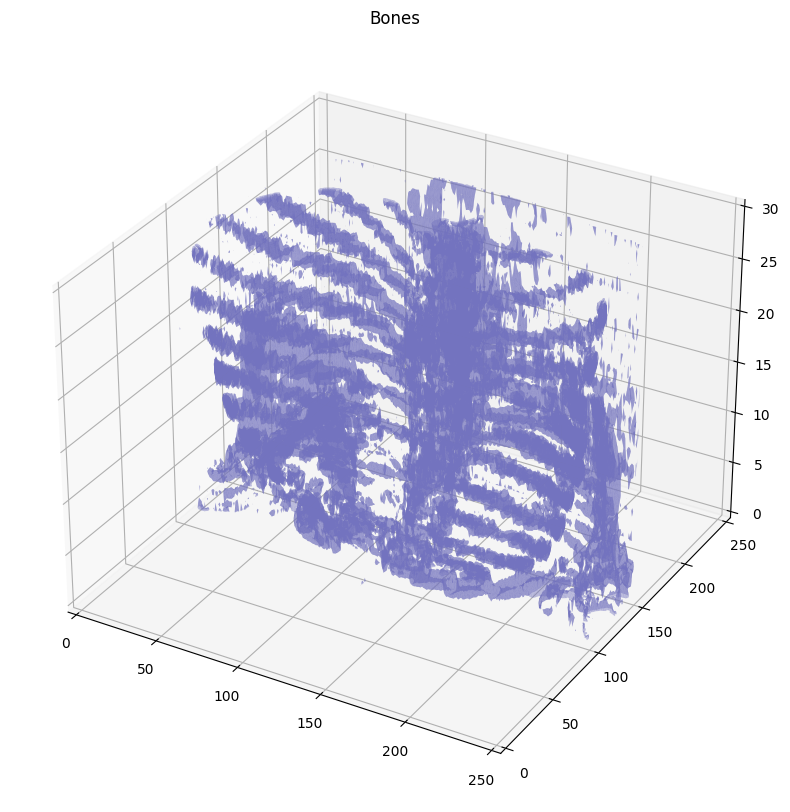

In [28]:
def plot_3d(image, title):

    # Position the scan upright,
    # so the head of the patient would be at the top facing the
    # camera
    p = image.transpose(2,1,0)

    verts, faces, _, _ = measure.marching_cubes(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.5)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    ax.set_title(title)
    plt.show()


# run visualization
plot_3d(bones, 'Bones')

In [29]:
def seg(path):
    img= load_image(path)
    img_thr= cv2.threshold(img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)[1]
    ex_con, in_con= find_contour(img_thr)
    seg_img= seg_lung(img, in_con)
    return find_contour(seg_img)[1]

In [30]:
# Stacking images
img=[]
path='/content/train/ID00007637202177411956430/'
for i in tqdm(range(1, 31)):
    path1= path+str(i)+'.dcm'
    image= cv2.resize(seg(path1), (250,250))
    img.append(image)


lung=np.array(img)
lung.shape

100%|██████████| 30/30 [02:06<00:00,  4.21s/it]


(30, 250, 250)

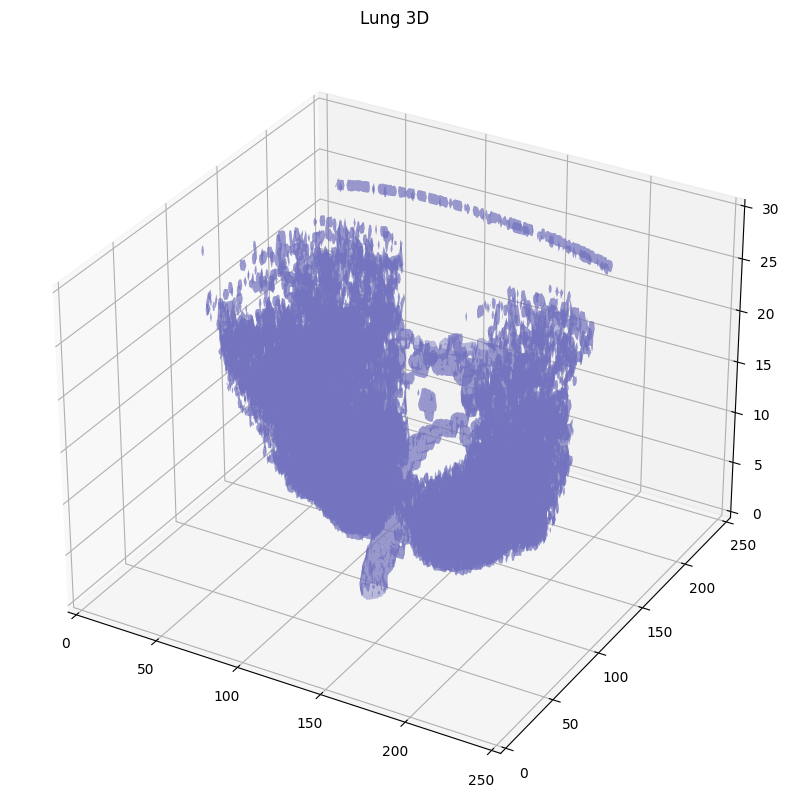

In [31]:
plot_3d(lung, 'Lung 3D')